In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Running the **Kaggle-provided code** above printed a full file list. After running it once, I commented out the file directory walk results to spare you the long list of every file. The important thing is the list revealed that there are four directories of data:

/kaggle/input/gan-getting-started/photo_jpg/ (*.jpg files)

/kaggle/input/gan-getting-started/monet_jpg/ (*.jpg files)

/kaggle/input/gan-getting-started/photo_tfrec/ (*.tfrec files)

/kaggle/input/gan-getting-started/monet_tfrec/ (*.tfrec files)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import GroupNormalization
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np
import re
import PIL
import shutil

Let's connect to our GPU and save its strategy.

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTO = tf.data.experimental.AUTOTUNE
print(tf.__version__)

Number of replicas: 1
2.16.1


In [4]:
# Google Cloud Storage path for dataset
DATA_ROOT = "/kaggle/input/gan-getting-started"
# Size of input data
MONET_GLOB = tf.io.gfile.glob(str(DATA_ROOT + '/monet_tfrec/*.tfrec'))
PHOTO_GLOB = tf.io.gfile.glob(str(DATA_ROOT + '/photo_tfrec/*.tfrec'))


In [5]:
countMonet = 0
countPhoto = 0
for eachFile in MONET_GLOB:
  strNumFiles = re.compile(r"-([0-9]*)\.").search(eachFile).group(1)
  countMonet += int(strNumFiles)
for eachFile in PHOTO_GLOB:
  strNumFiles = re.compile(r"-([0-9]*)\.").search(eachFile).group(1)
  countPhoto += int(strNumFiles)

print("Number of photos: ", countPhoto)
print("Number of Monet paintings: ", countMonet)

Number of photos:  7038
Number of Monet paintings:  300


In [6]:
IMAGE_WIDTH = 256 # ditto for the height
TWICE_WIDTH = IMAGE_WIDTH * 2
HALF_WIDTH = IMAGE_WIDTH // 2
QUARTER_WIDTH = IMAGE_WIDTH // 4

def readTF(x):
  tfRecordFormat = {"image_name": tf.io.FixedLenFeature([], tf.string),
      "image": tf.io.FixedLenFeature([], tf.string),
      "target": tf.io.FixedLenFeature([], tf.string)}
  x = tf.io.parse_single_example(x, tfRecordFormat)

  tfImage = tf.image.decode_jpeg(x["image"], channels = 3)
  tfImage = (tf.cast(tfImage, tf.float32) / 127.5) - 1
  tfImage = tf.reshape(tfImage, [IMAGE_WIDTH, IMAGE_WIDTH, 3])

  return tfImage

In [7]:
def augmentImage(image):
  # Get random percentages to see whether we change the image
  pCrop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
  pRotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
  pFlip = tf.random.uniform([], 0, 1.0, dtype=tf.float32)

  if pCrop > .5:
    BIG_IMAGE = IMAGE_WIDTH + 30
    bigImage = tf.image.resize(image, [BIG_IMAGE, BIG_IMAGE])
    image = tf.image.random_crop(bigImage, size = [IMAGE_WIDTH, IMAGE_WIDTH, 3])
    if pCrop > .9:
      HUGE_IMAGE = IMAGE_WIDTH + 60
      hugeImage = tf.image.resize(image, [HUGE_IMAGE, HUGE_IMAGE])
      image = tf.image.random_crop(hugeImage, size = [IMAGE_WIDTH, IMAGE_WIDTH, 3])

  if pRotate > .9:
    image = tf.image.rot90(image, k = 3)
  elif pRotate > .7:
    image = tf.image.rot90(image, k = 2)
  elif pRotate > .5:
    image = tf.image.rot90(image, k = 1)

  if pFlip > .6:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if pFlip > .9:
      image = tf.image.transpose(image)

  return image

In [8]:
def loadTFDataset(filenames):
  tfDataset = tf.data.TFRecordDataset(filenames)
  dataset = tfDataset.map(map_func = readTF, num_parallel_calls = tf.data.AUTOTUNE)
  return dataset

def ganDataset(monetFiles, photoFiles,
                augment = None, repeat = True,
                shuffle = True, batch_size = 1):
  tfMonet = loadTFDataset(monetFiles)
  tfPhoto = loadTFDataset(photoFiles)

  if augment:
    tfMonet = tfMonet.map(map_func = augment, num_parallel_calls = tf.data.AUTOTUNE)
    tfPhoto = tfPhoto.map(map_func = augment, num_parallel_calls = tf.data.AUTOTUNE)
  if repeat:
    tfMonet = tfMonet.repeat()
    tfPhoto = tfPhoto.repeat()
  if shuffle:
    tfMonet = tfMonet.shuffle(2048)
    tfPhoto = tfPhoto.shuffle(2048)

  tfMonet = tfMonet.batch(batch_size, drop_remainder = True)
  tfPhoto = tfPhoto.batch(batch_size, drop_remainder = True)
  tfMonet = tfMonet.cache()
  tfPhoto = tfPhoto.cache()
  tfMonet = tfMonet.prefetch(tf.data.AUTOTUNE)
  tfPhoto = tfPhoto.prefetch(tf.data.AUTOTUNE)

  dsResult = tf.data.Dataset.zip((tfMonet, tfPhoto))

  return dsResult

It's time to load the full dataset and look at some samples.

In [9]:
fullData = ganDataset(MONET_GLOB, PHOTO_GLOB,
                      augment = augmentImage, repeat = True,
                      shuffle = True, batch_size = 4)

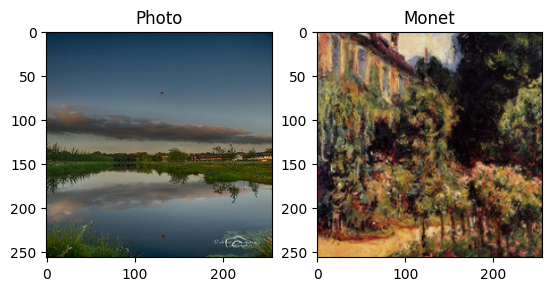

In [10]:
monetSample, photoSample = next(iter(fullData))
plt.subplot(121)
plt.title('Photo')
plt.imshow(photoSample[0] * 0.5 + 0.5)
plt.subplot(122)
plt.title('Monet')
plt.imshow(monetSample[0] * 0.5 + 0.5)

In [11]:
def downSample(filters, kernel_size, instanceNorm = True):
  dsInit = tf.random_normal_initializer(mean = 0.0, stddev = 0.02)
  gammaRandomInit = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

  dsLayer = keras.Sequential()
  dsLayer.add(layers.Conv2D(filters, kernel_size, strides = 2, padding='same',
                            kernel_initializer = dsInit, use_bias = False))
  if instanceNorm:
    dsLayer.add(GroupNormalization(groups = -1, gamma_initializer = gammaRandomInit))
  dsLayer.add(layers.LeakyReLU())

  return dsLayer

In [12]:
def upSample(filters, kernel_size, dropout = False):
  upInit = tf.random_normal_initializer(mean = 0.0, stddev = 0.02)
  gammaRandomInit = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

  upLayer = keras.Sequential()
  upLayer.add(layers.Conv2DTranspose(filters, kernel_size, strides = 2, padding = 'same',
                                    kernel_initializer = upInit, use_bias = False))
  upLayer.add(GroupNormalization(groups = -1, gamma_initializer = gammaRandomInit))
  if dropout:
    upLayer.add(layers.Dropout(0.5))
  upLayer.add(layers.ReLU())

  return upLayer

In [13]:
def modelGenerator():
  layerInputs = layers.Input(shape = [IMAGE_WIDTH, IMAGE_WIDTH, 3])
  downLayers = [downSample(QUARTER_WIDTH, 4, instanceNorm = False),
                downSample(HALF_WIDTH, 4),
                downSample(IMAGE_WIDTH, 4),
                downSample(TWICE_WIDTH, 4),
                downSample(TWICE_WIDTH, 4),
                downSample(TWICE_WIDTH, 4),
                downSample(TWICE_WIDTH, 4),
                downSample(TWICE_WIDTH, 4)]

  upLayers = [upSample(TWICE_WIDTH, 4, dropout = True),
              upSample(TWICE_WIDTH, 4, dropout = True),
              upSample(TWICE_WIDTH, 4, dropout = True),
              upSample(TWICE_WIDTH, 4),
              upSample(IMAGE_WIDTH, 4),
              upSample(HALF_WIDTH, 4),
              upSample(QUARTER_WIDTH, 4)]

  genInit = tf.random_normal_initializer(mean = 0.0, stddev = 0.02)
  last = layers.Conv2DTranspose(filters = 3, kernel_size = 4,
                                strides = 2, padding = 'same',
                                kernel_initializer = genInit,
                                activation='tanh')

  skipSet = []
  outputRows = layerInputs
  for eachLayer in downLayers:
    outputRows = eachLayer(outputRows)
    skipSet.append(outputRows)

  skipSet = reversed(skipSet[:-1])
  for eachLayer, eachSkip in zip(upLayers, skipSet):
    outputRows = eachLayer(outputRows)
    outputRows = layers.Concatenate()([outputRows, eachSkip])
  outputRows = last(outputRows)

  return keras.Model(inputs = layerInputs, outputs = outputRows)

In [14]:
def modelDiscriminator():
  discInit = tf.random_normal_initializer(mean = 0.0, stddev = 0.02)
  gammaRandomInit = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

  layerInputs = layers.Input(shape = [IMAGE_WIDTH, IMAGE_WIDTH, 3])
  ds1 = downSample(QUARTER_WIDTH, 4, instanceNorm = False)(layerInputs)
  ds2 = downSample(HALF_WIDTH, 4)(ds1)
  ds3 = downSample(IMAGE_WIDTH, 4)(ds2)

  padded1 = layers.ZeroPadding2D(padding = (1, 1))(ds3)
  convTensor = layers.Conv2D(filters = TWICE_WIDTH, kernel_size = 4, strides = 1,
                       kernel_initializer = discInit,
                       use_bias = False)(padded1)
  normed = GroupNormalization(groups = -1, gamma_initializer = gammaRandomInit)(convTensor)
  lrLayer = layers.LeakyReLU(negative_slope = 0.3)(normed)
  padded2 = layers.ZeroPadding2D(padding = (1, 1))(lrLayer)
  outputTensor = layers.Conv2D(filters = 1, kernel_size = 4, strides = 1,
                               kernel_initializer = discInit)(padded2)

  return tf.keras.Model(inputs = layerInputs, outputs = outputTensor)

Per Slack note from Salim H, April 3, 2023:

"There is a tutorial in the kaggle challenge description that shows you how to implement a CycleGan. I verified with Sana (our TA) that it’s ok to lift and shift that code over. You should write your own generator and discriminator models but you’re not expected to implement CycleGan on your own."

So here is that relevant chunk of code from https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial


In [15]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [16]:
with strategy.scope():
  monetGen = modelGenerator()
  photoGen = modelGenerator()

  monetDisc = modelDiscriminator()
  photoDisc = modelDiscriminator()

In [17]:
with strategy.scope():
  def genLoss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits = True,
                                              label_smoothing = 0.0,
                                              reduction = None)(tf.ones_like(generated), generated)

In [18]:
with strategy.scope():
  def discLoss(target, test):
    targetLoss = tf.keras.losses.BinaryCrossentropy(from_logits = True,
                                                    label_smoothing = 0.0,
                                                    reduction = None)(tf.ones_like(target), target)
    testLoss = tf.keras.losses.BinaryCrossentropy(from_logits = True,
                                                  label_smoothing = 0.0,
                                                  reduction = None)(tf.zeros_like(test), test)
    return (targetLoss + testLoss) * 0.5

In [19]:
with strategy.scope():
  def cycleLoss(imageReal, imageCycled, LAMBDA):
    rawLoss = tf.reduce_mean(tf.abs(imageReal - imageCycled))
    return LAMBDA * rawLoss

In [20]:
with strategy.scope():
  def idLoss(imageReal, imageMatch, LAMBDA):
    rawLoss = tf.reduce_mean(tf.abs(imageReal - imageMatch))
    return LAMBDA * 0.5 * rawLoss

In [21]:
with strategy.scope():
  ganModel = CycleGan(monetGen, photoGen, monetDisc, photoDisc)

  ganModel.compile(m_gen_optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-4, beta_1 = 0.5),
                   p_gen_optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-4, beta_1 = 0.5),
                   m_disc_optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-4, beta_1 = 0.5),
                   p_disc_optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-4, beta_1 = 0.5),
                   gen_loss_fn = genLoss,
                   disc_loss_fn = discLoss,
                   cycle_loss_fn = cycleLoss,
                   identity_loss_fn = idLoss)

In the Kaggle environment, the following model fit ran out of memory and crashed on its third epoch. That's why I'm limiting it to two.

In [22]:
ganModel.fit(fullData, epochs = 2, steps_per_epoch = (max(countMonet, countPhoto) // 5))

Epoch 1/2


I0000 00:00:1732292706.591488     316 service.cc:145] XLA service 0x7a78440042d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732292706.591562     316 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1732292772.020587     316 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 523s 299ms/step - monet_disc_loss: 0.6355 - monet_gen_loss: 3.5378 - photo_disc_loss: 0.5821 - photo_gen_loss: 3.7445
Epoch 2/2
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 420s 299ms/step - monet_disc_loss: 0.6256 - monet_gen_loss: 2.7266 - photo_disc_loss: 0.6113 - photo_gen_loss: 2.8276


In [23]:
def storeOutput(tfdInput, genModel, outputDir):
  outputCounter = 1
  for eachImage in tfdInput:
    predImageData = genModel(eachImage, training = False)[0].numpy()
    predImageData = (predImageData * 127.5 + 127.5).astype(np.uint8)
    outputImage = PIL.Image.fromarray(predImageData)
    outputImage.save(f'{outputDir}{str(outputCounter)}.jpg')
    outputCounter += 1
    if (outputCounter % 200) == 0:
      print("Images: ", outputCounter)

In [24]:
os.makedirs('../images/')
storeOutput(loadTFDataset(PHOTO_GLOB).batch(1), monetGen, '../images/')
shutil.make_archive('/kaggle/working/images', 'zip', '../images')
print(f"Generated samples: {len([name for name in os.listdir('../images/') if os.path.isfile(os.path.join('../images/', name))])}")

Images:  200
Images:  400
Images:  600
Images:  800
Images:  1000
Images:  1200
Images:  1400
Images:  1600
Images:  1800
Images:  2000
Images:  2200
Images:  2400
Images:  2600
Images:  2800
Images:  3000
Images:  3200
Images:  3400
Images:  3600
Images:  3800
Images:  4000
Images:  4200
Images:  4400
Images:  4600
Images:  4800
Images:  5000
Images:  5200
Images:  5400
Images:  5600
Images:  5800
Images:  6000
Images:  6200
Images:  6400
Images:  6600
Images:  6800
Images:  7000
Generated samples: 7038
